### INITIAL IMPORTS

In [1]:
import requests
import pandas as pd
import numpy as np
from collections import defaultdict
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
import random
from mesa.space import NetworkGrid
import networkx as nx
from datetime import datetime, timedelta
from collections import defaultdict
from mesa.datacollection import DataCollector
from datetime import datetime


# DATA COLLECTION

To collect data about flights, FlightLabsAPI has been used. This web API provides flights' information for almost every European airport. These information include the source, destination, departure time, delay, airline's name, airline's IATA identifier... In particular, for the sake of this project, data for the 50 most crowded (on a yearly basis) European airports has been used (mostly taken from https://gettocenter.com/airports/continent/europe) and has be defined hereafter:

In [39]:
tag_airports = [
    "LHR", # London Heathrow Airport
    "CDG", # Paris-Charles de Gaulle Airport
    "AMS", # Amsterdam Airport Schiphol
    "FRA", # Frankfurt Airport
    "IST", # Istanbul Airport
    "BCN", # Barcelona-El Prat Airport
    "MAD", # Adolfo Suárez Madrid–Barajas Airport
    "MUC", # Munich Airport
    "SAW", # Sabiha Gökçen International Airport
    "FCO", # Leonardo da Vinci-Fiumicino Airport
    "LGW", # London Gatwick Airport
    "DME", # Moscow Domodedovo Airport
    "ORY", # Paris Orly Airport
    "VIE", # Vienna International Airport
    "ZRH", # Zurich Airport
    "OTP", # Henri Coandă International Airport
    "SVO", # Sheremetyevo International Airport
    "CPH", # Copenhagen Airport
    "ATH", # Athens International Airport
    "ARN", # Stockholm Arlanda Airport
    "DUB", # Dublin Airport
    "OSL", # Oslo Airport, Gardermoen
    "HAM", # Hamburg Airport
    "BRU", # Brussels Airport
    "LIS", # Lisbon Portela Airport
    "BGY", # Milan Bergamo Airport
    "HEL", # Helsinki Airport
    "MAN", # Manchester Airport
    "BUD", # Budapest Ferenc Liszt International Airport
    "PRG", # Prague Václav Havel Airport
    "WAW", # Warsaw Chopin Airport
    "EDI", # Edinburgh Airport
    "GVA", # Geneva Airport
    "DUS", # Düsseldorf Airport
    "SXF", # Berlin Schönefeld Airport
    "BLL", # Billund Airport
    "AGP", # Málaga Costa del Sol Airport
    "NCE", # Nice Côte d'Azur Airport
    "PMI", # Palma de Mallorca Airport
    "STR", # Stuttgart Airport
    "NAP", # Naples International Airport
    "LED", # Pulkovo Airport
    "LTN", # London Luton Airport
    "TLS", # Toulouse Blagnac Airport
    "BHX", # Birmingham Airport
    "LPA", # Gran Canaria Airport
    "KEF", # Keflavík International Airport
    "SZG", # Salzburg Airport
    "AYT", # Antalya Airport
    "MXP" # Milan Malpensa Airport
]

A function to calculate time intervals was then defined given that the API used only allows extraction for a time window of a maximum of ***** days for big airports, category in which many airports amongst the ones under consideration fall. The function was defined as follows:

In [267]:
import datetime
def time_period(date_from, date_to):
    interval_d = datetime.timedelta(days=1)
    interval_4d = datetime.timedelta(days=3)
    out = []
    while date_from <= date_to:
        i = datetime.datetime.strptime(date_from, "%Y-%m-%d")
        j = (i + interval_4d).strftime("%Y-%m-%d")
        date_from = (i+ (interval_d + interval_4d)).strftime("%Y-%m-%d")
        i = i.strftime("%Y-%m-%d")
        out.append((i,j))
    return out

The main information about all flights has then been extracted for the period under analysis (January 2023 - April 2023) and stored in a dataframe (the try/except architecture was necessary as sometimes FlightLabs does not provide some particular information, maybe beacuse of a mulfunctioning of the measuring instruments, though, amongst the flights APIs tried, FlightLabs seemed to be the most complete):

In [268]:
def get_flight(airports,date_from,date_to):
    df = defaultdict(list)
    interval = time_period(date_from,date_to)
    for w,k in interval:
        for j in airports:
            api_key='insert_API_key_here'
            response = requests.get(f'https://app.goflightlabs.com/historical/{w}?access_key={api_key}&code={j}&type=departure&date_to={k}')
            data=response.json()["data"]
            
            for i in range(len(data)):
                try:
                    df['dep_iata'].append(data[i]['departure']['iataCode'])
                    df['dep_sch'].append(data[i]['departure']['scheduledTime'])
                    if 'delay' in data[i]['departure']:
                        df['dep_delay'].append(data[i]['departure']['delay'])
                    else:
                        df['dep_delay'].append(None)
                    if 'estimatedTime' in data[i]['departure']:
                        df['dep_est'].append(data[i]['departure']['estimatedTime'])
                    else:
                        df['dep_est'].append(None)
                    
                    if 'actualTime' in data[i]['departure']:
                        df['dep_act'].append(data[i]['departure']['actualTime'])
                    else:
                        df['dep_act'].append(None)
                    if 'iataCode' in data[i]['arrival']:
                        df['arr_iata'].append(data[i]['arrival']['iataCode'])
                    else:
                        df['arr_iata'].append(None)
                    if 'scheduledTime' in data[i]['arrival']:
                        df['arr_sch'].append(data[i]['arrival']['scheduledTime'])
                    else:
                        df['arr_sch'].append(None)
                    if 'iataCode' in data[i]['airline']:
                        df['iata_airline'].append(data[i]['airline']['iataCode'])
                    else:
                        df['iata_airline'].append(None)
                    if 'name' in data[i]['airline']:
                        df['name_airline'].append(data[i]['airline']['name'])
                    else:
                        df['name_airline'].append(None)
                    if 'iataNumber' in data[i]['flight']:
                        df['iata_flight'].append(data[i]['flight']['iataNumber'])
                    else:
                        df['iata_flight'].append(None)
                except:
                    df['dep_iata'].append(None)
                    df['dep_sch'].append(None)
                    df['dep_delay'].append(None)
                    df['dep_est'].append(None)
                    df['dep_act'].append(None)
                    df['arr_iata'].append(None)
                    df['arr_sch'].append(None)
                    df['iata_airline'].append(None)
                    df['name_airline'].append(None)
                    df['iata_flight'].append(None)
                    
    return pd.DataFrame(df)

The above function was then called for all the months of the analysis (namely January, February, March and April 2023):

In [269]:
data_frame = get_flight(tag_airports,'2023-01-1','2023-01-31')

Then, only the flights departing and landing within the 50 airports under analysis were kept (this represented the vast majority):

In [270]:
final=data_frame[data_frame['arr_iata'].isin([x.lower() for x in tag_airports])].reset_index(drop=True)

At this point, there were some dublicated flights due to the presence of codeshares. Codesharing is a practice in the airline industry where two or more airlines jointly market and operate a flight under their own airline codes (typically referred to as the IATA airline codes). This means that passengers can book a flight with one airline, but the actual flight may be operated by another airline. In this analysis' case, the problem was that the dataframe created with the steps above was not able to distinguish between the two airlines. For example, if a flight from London to Paris was operated by both Air France and British Airways, the dataframe would have considered it as two different flights, one operated by Air France and one by British Airways. The following function was them defined to drop duplicates and keep only the "real flight" of the "real company" that has operated it:

In [272]:
l=[]
for i in range(0,len(final)-1):
    if final.loc[i,"dep_iata"]==final.loc[i+1,"dep_iata"] and final.loc[i,"arr_iata"]==final.loc[i+1,"arr_iata"] and final.loc[i,"dep_sch"]==final.loc[i+1,"dep_sch"] and final.loc[i,"arr_sch"]==final.loc[i+1,"arr_sch"]:
        l.append(i)
final=final.drop(l).reset_index(drop=True)

Then, information about the 50 airports under analysis was extracted from the airports endpoint of the FlightLabs API. This information include longitude and latitude necessary for the plotting procedure conducted below in the code. Once again, the function stores the result into a dataframe.

In [42]:
def get_airport(airports):
    df = defaultdict(list)
    for j in airports:
        api_key='insert_API_key_here'
        response = requests.get(f'https://app.goflightlabs.com/airports?access_key={api_key}&codeIataAirport={j}')
        data=response.json()["data"]
        df["iata"].append(data[0]["codeIataAirport"])
        df["longitude"].append(data[0]["longitudeAirport"])
        df["latitude"].append(data[0]["latitudeAirport"])
        df["name"].append(data[0]["nameAirport"])
        df["country"].append(data[0]["nameCountry"])         
    return pd.DataFrame(df)

In [43]:
arp=get_airport(tag_airports)

All the dataframes were then saved as csv files so as not to have to make other calls to the API again. As a matter of facts making extra requestes to the FlightLabs API is not only time consuming but is also costly.

In [ ]:
arp.to_csv('airports_top50.csv',index=False)

In [274]:
final.to_csv('flights_january2023.csv',index=False)

Then, the databases about flights have been (one at a time) cleaned and the date columns have been formatted. Moreover, they have been saved once again in their final form ready for the epidemy simulation:

In [ ]:
final=pd.read_csv('flights_january2023.csv')

In [276]:
final["dep_sch_f"]=final["dep_sch"].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f'))
final["arr_sch_f"]=final["arr_sch"].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f'))
final["dep_date"] = final["dep_sch_f"].apply(lambda x: x.date())
final["dep_time"] = final["dep_sch_f"].apply(lambda x: x.time())
final["arr_date"] = final["arr_sch_f"].apply(lambda x: x.date())
final["arr_time"] = final["arr_sch_f"].apply(lambda x: x.time())

In [277]:
final.drop(columns=["dep_sch","arr_sch","dep_delay","dep_est","dep_act","dep_sch_f","arr_sch_f"],inplace=True)

In [278]:
final.to_csv('flights_january2023_epidemy.csv',index=False)

Then, a visual plot of the network has been obtained with for the 1st January 2023:

In [279]:
final=pd.read_csv('flights_january2023_epidemy.csv')

In [280]:
final_modd=final.groupby(['dep_iata','dep_date','arr_iata']).count().reset_index()

In [281]:
import math

def data_to_map(final_modd, arp, day):
    final_modd = final_modd[final_modd['dep_date'] == day]
    # Create map
    map = folium.Map(location=[51.5072, -0.1276], zoom_start=4)

    # Define color function based on count of flights
    color_scale = folium.LinearColormap(
        ["green", "yellow", "red"],
        vmin=final_modd["name_airline"].min(),
        vmax=final_modd["name_airline"].max(),
    )

    # Add markers for airports
    for index, airport in arp.iterrows():
        folium.Marker(
            location=[airport["latitude"], airport["longitude"]],
            popup=f"{airport['name']}, {airport['country']} ({airport['iata']})",
            icon=folium.Icon(color="blue", icon="plane"),
        ).add_to(map)

    # Add connections between airports
    for index, route in final_modd.iterrows():
        source = route["dep_iata"].upper()
        dest = route["arr_iata"].upper()
        if source and dest:
            coords = [
                (float(arp[arp["iata"]==source]["latitude"]), float(arp[arp["iata"]==source]["longitude"])),
                (float(arp[arp["iata"]==dest]["latitude"]), float(arp[arp["iata"]==dest]["longitude"])),
            ]
            count = route["name_airline"]
            color = color_scale(count)
            weight = 5 if count > 10 else 3
            arrow_pos = 1.0 - weight / 20
            arrow_angle = math.atan2(coords[1][1] - coords[0][1], coords[1][0] - coords[0][0]) * 180 / math.pi
            arrow_icon = folium.Icon(
                icon="arrow-up",
                prefix="fa",
                color=color,
                angle=arrow_angle,
            )
            folium.PolyLine(
                locations=coords,
                color=color,
                weight=weight,
                opacity=1,
                smooth_factor=1,
                tooltip=str(count),
                dash_array=[],
                dash_offset="0",
                fill=False,
                line_cap="round",
                line_join="round",
                show=True,
                plugin_data=None,
                clustered_marker=False,
                icon=arrow_icon,
                arrow_pos=arrow_pos,
                arrow_style="simple",
                arrow_size=10,
                arrow_fill_color=color,
                arrow_stroke_color=color,
            ).add_to(map)

    # Add color legend
    color_scale.add_to(map)

    # Return map object
    return map

In [292]:
map=data_to_map(final_modd,arp,'2023-01-01')
display(map)

/var/folders/hx/n0zcsqj95pq2sj7w5hfh23qm0000gn/T/ipykernel_1198/1937517563.py:35: UserWarning: color argument of Icon should be one of: {'green', 'beige', 'red', 'purple', 'darkred', 'blue', 'gray', 'cadetblue', 'pink', 'lightred', 'darkpurple', 'darkblue', 'lightblue', 'lightgreen', 'darkgreen', 'lightgray', 'black', 'orange', 'white'}.
  arrow_icon = folium.Icon(


# SIMULATION IN SCENARIO 1: NO INTERVENTION

First of all, the previously created databases have been loaded and merged into a single one which will be then the one used into the simulation:

In [3]:
fj=pd.read_csv("flights_january2023_epidemy.csv")
ff=pd.read_csv("flights_february2023_epidemy.csv")
fm=pd.read_csv("flights_march2023_epidemy.csv")
fa=pd.read_csv("flights_april2023_epidemy.csv")
ffinal=pd.concat([fj,ff,fm,fa]).reset_index(drop=True)

Then, given that the aim of the study is to analyze the spread of an epidemy, we will drop all the cargo flights which do not carry passengers and hence are not vectors for the disease. To do so, all those flights which have as "iata_airline" (the IATA code of the flight) one corresponding to a major cargo airline have been dropped:

In [4]:
to_drop=[]
for i in range(len(ffinal)):
    if ffinal.loc[i,"iata_airline"] in ["5y", "lh", "af", "cv", "tk", "d0", "ba", "ek", "ay", "lx", "ru", "fx"]:
        to_drop.append(i)
ffinal.drop(to_drop,inplace=True)

And then the newly obtained dataframe was saved so that it can later be used also for the other scenarios:

In [5]:
ffinal.to_csv("flights_2023_epidemy.csv",index=False)

Then, the databases necessary to run the simulation have been imported (SXF, namely Berlin's airport, was removed as there seems that no record of flights are available for that airport, this could be due to a data loss or a connection issue when making requests to the web API):

In [2]:
airports=pd.read_csv("airports_top50.csv")
fj=pd.read_csv("flights_2023_epidemy.csv")
airports.drop(airports[airports["iata"]=="SXF"].index,inplace=True)
airports.reset_index(drop=True,inplace=True)

At this point, given that the study is focusing on passenger movements, flights between the same airport have been removed. Indeed, sometimes, some companies perform, for instance, crew_training flights or exibition flights which depart and land at the same airport. These flights do not bring passengers and hence have been dropped. Moreover, also the flights of the first three days of May have been dropped given that this analysis focuses on the period January-April (these first day of May were downloaded from the API when downloading the ones of the 30th of Aprik=l, but are not relevant for this analysis):

In [3]:
fj.drop(fj[fj["dep_iata"]==fj["arr_iata"]].index,inplace=True)
fj.drop(fj[fj["dep_date"]=="2023-05-01"].index, inplace=True)
fj.drop(fj[fj["dep_date"]=="2023-05-02"].index, inplace=True)
fj.drop(fj[fj["dep_date"]=="2023-05-03"].index, inplace=True)

At this point, the dictionary containing the capacity of the airports has been created based on the actual number of passengers in a year:

In [4]:
air_cap=defaultdict(int)
for i in range(len(airports)):
    air_cap[airports.loc[i,"iata"]]=1000

Then, also the dictionary for the daily probabilities of moving from a certain source airport to another destination airport has been created with the following code. In particular, the probabilities have been computed has the number of flights connecting source to destination and dividing it by the total number of flights departing from the source airport that same day:

In [5]:
aux=fj.groupby(["dep_iata","dep_date","arr_iata"]).count().reset_index()
prob=defaultdict(dict)
for i in range(len(aux)):
    prob[aux.loc[i,"dep_date"]][aux.loc[i,"dep_iata"]]={}
for i in range(len(aux)):
    prob[aux.loc[i,"dep_date"]][aux.loc[i,"dep_iata"]].update({aux.loc[i,"arr_iata"]:aux.loc[i,"name_airline"]})

for date, airports_ in prob.items():
    for source, destinations in airports_.items():
        total_flights = sum(destinations.values())
        for destination, num_flights in destinations.items():
            prob[date][source][destination] = num_flights / total_flights

Then, a dictionary containing as key the source airport and as values the lists containing all the destinations reachable from that specific source airport. This will be later used in the model class to create the network grid. Moreover, there all connections will be created irrespective if there is or not a flight between the two airports on a given day. This is because the model will later use the daily probabilities to decide whether or not a flight will be performed, and, if there are no connections between two airports in a given day, then the probability of moving between the two airports will automatically be zero. The code to create this dictionary is as follows:

In [6]:
flight_dict = {}
for _, row in fj.iterrows():
    source = row["dep_iata"]
    destination = row["arr_iata"]
    if source not in flight_dict:
        flight_dict[source] = []
    if destination not in flight_dict[source]:
        flight_dict[source].append(destination)

### Actual Model

In [7]:
def compute_S(model):
    S_per_airport = defaultdict(int)
    for a in model.schedule.agents:
        current = a.pos
        if a.health == 'Susceptible':
            S_per_airport[current] += 1
    return S_per_airport

def compute_I(model):
    I_per_airport = defaultdict(int)
    for a in model.schedule.agents:
        current = a.pos
        if a.health == 'Infected':
            I_per_airport[current] += 1
    return I_per_airport

def compute_R(model):
    R_per_airport = defaultdict(int)
    for a in model.schedule.agents:
        current = a.pos
        if a.health == 'Recovered':
            R_per_airport[current] += 1
    return R_per_airport

In [8]:
# def compute_S(model):
#     return  sum([1 for a in model.schedule.agents if a.health == 'Susceptible'])

# def compute_I(model):
#     return  sum([1 for a in model.schedule.agents if a.health == 'Infected'])

# def compute_R(model):
#     return  sum([1 for a in model.schedule.agents if a.health == 'Recovered'])

In [24]:
class SIR_Agent(Agent):
    #ALL AGENTS WILL BE INITIALISED AS SUSCEPTIBLE. THE INFECTED AGENTS WILL BE THEN DEFINED IN THE MODEL CLASS
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.health = 'Susceptible'
        
        #ADD THE TIMESLEEP FOR THE AVARAGE STAY IN A CITY (WHICH SHOULD BE AN INTEGER AND HAS BEEN DRAWN FROM A NORMAL DISTRIBUTION CENTERED AROUND 3
        #WHICH WAS FOUND TO BE THE AVERAGE STAY IN A EUROPEAN CITY)
        time_sleep = int(random.gauss(3, 1)) 
        #TO MAKE SURE THE TIMESLEEP IS NON NEGATIVE, THE MAX BETWEEN THE OBTAINED RESULT AND 1 IS TAKEN
        self.time_sleep = max(time_sleep, 1)

        #ADDING AN ATTRIBUTE INDICATE THE HOME NODE, MEANING THE INITIAL NODE OF THE AGENT. INITIALLY, THIS WILL BE SET TO NONE AND CHANGED WHEN 
        #ASSIGNING THE AGENT TO A SPECIFIC INITIAL AIRPORT
        self.home_node = None
    
    def move(self):
        current_node = self.pos
        #NEIGHBORS ARE THE AIRPORTS THAT ARE CONNECTED TO THE CURRENT AIRPORT
        neighbors = self.model.grid.get_neighbors(current_node)
        valid_neighbors = [n for n in neighbors if n in self.model.airports_graph.neighbors(current_node)]
        if valid_neighbors:
            #THE NEW POSITION IS COMPUTED ACCORDING TO THE PROBABILITY OF THE FLIGHT IN THE GIVEN DAY, WHICH IS STORED IN THE PROB DICTIONARY
            #THE TRY/EXCEPT ARCHITECTURE IS NEEDED SINCE, IN SOME DAYS, THERE ARE EITHER NO FLIGHTS FROM SOME AIRPORTS OR FLIGHTLABS API DID NOT PROVIDE
            #INFROMATION ABOUT THEM
            try:
                #IF THE AGENT IS NOT IN HIS HOME NODE, HE WILL MOVE THERE WITH A PROBABILITY OF 80%, ELSE HE WILL MOVE TO ANOTHER 
                #AIRPORT WITH A PROBABILITY COMPUTED AS MENTIONED ABOVE
                if current_node.lower()!=self.home_node.lower():
                    if random.random() < 0.8:
                        self.model.grid.move_agent(self, self.home_node)
                    else:
                        desti=list(self.model.prob[self.model.day][current_node.lower()].keys())
                        probabilities = [self.model.prob[self.model.day][current_node.lower()][n.lower()] for n in valid_neighbors if n.lower() in self.model.prob[self.model.day][current_node.lower()].keys()]
                        new_position = np.random.choice(desti, p=probabilities)
                        self.model.grid.move_agent(self, new_position.upper())
                else:
                    desti=list(self.model.prob[self.model.day][current_node.lower()].keys())
                    probabilities = [self.model.prob[self.model.day][current_node.lower()][n.lower()] for n in valid_neighbors if n.lower() in self.model.prob[self.model.day][current_node.lower()].keys()]
                    new_position = np.random.choice(desti, p=probabilities)
                    self.model.grid.move_agent(self, new_position.upper())
            except:
                self.model.grid.move_agent(self, current_node)

        
    def try_to_infect_neighbors(self):
        ##DEFINE THE NEIGHBORS AS THOSE AGENTS IN THE SAME CELL
        current_node = self.pos
        susceptible_neighbors = [a for a in self.model.grid.get_cell_list_contents([current_node]) if (a.health == 'Susceptible') and (random.random() < 0.005)]

        for a in susceptible_neighbors:
            if self.random.random() < self.model.beta: #HA SENSO IL BETA COSI????
                a.health = 'Infected'
    
    def try_to_recovery(self):
        if random.random() < 1 / (self.model.gamma):
            self.health ='Recovered'      
                    
    def step(self):
        #ADD TIMESLEEP FOR DAYS OF STAY
        if self.time_sleep > 0:
            self.time_sleep -= 1
        else:
            self.move()
            if self.health == 'Infected':
                self.try_to_infect_neighbors()
                self.try_to_recovery()
            #RESET TIMESLEEP
            time_sleep = int(random.gauss(3, 1))  
            self.time_sleep = max(time_sleep, 1)
                
    

class SIR_Model(Model):
    """SIR MODEL: """
    def __init__(self, air_cap, beta, gamma, beg_day, beg_airports, airports, flights, dest, prob):

        #THE NUMBER OF AGENTS WAS SET EQUAL TO SUM OF CAPACITIES OF AIRPORTS
        self.dict=air_cap
        self.num_agents = sum(self.dict.values())
        #AND THE AIRPORTS FROM WHICH THE EPIDEMIC WILL START HAVE BEEN SELECTED
        self.s_airports=beg_airports

        #ASWELL AS THE DATAFRAME OF THE AIRPORTS AND THE FLIGHTS, AND THE TWO CREATED DICTIONARIES FOR THE DESTINATIONS AND THE PROBABILITIES AS WELL
        #AS THE STARTING DATE WHICH WILL BE USED LATER IN THE CODE
        self.airports=airports
        self.fj=flights
        self.dest=dest
        self.prob=prob
        self.day = beg_day

        ##CREATE THE GRID WITH AIRPORTS AND CONNECTIONS
        self.airports_graph = nx.Graph()
        for i, airport_id in enumerate(list(self.airports["iata"])):
            longitude, latitude = self.airports.loc[i,"longitude"], self.airports.loc[i,"latitude"]
            self.airports_graph.add_node(airport_id, pos=(longitude, latitude))
        
        for i in self.dest.keys():
            source_airport = i.upper()
            for dest_airport in self.dest[i]:
                if not self.airports_graph.has_edge(source_airport, dest_airport.upper()):
                    self.airports_graph.add_edge(source_airport, dest_airport.upper())
        #################################

        self.grid = NetworkGrid(self.airports_graph)
        self.schedule = RandomActivation(self)
        self.beta = beta
        self.gamma = gamma
        self.running = True
        
        ##ADDING AN ATTENTION VARIABLE NECESSARY THEN TO CORRECTLY SET THE INITIAL INFECTED AGENTS
        att=0

        ##ADDING AGENTS TO THE MODEL
        for i in range(self.num_agents):
            a = SIR_Agent(i, self)
            self.schedule.add(a)
            #PUT AGANTS IN AIRPORTS UNTIL THE CAPACITY IS REACHED
            for initial_airport in self.dict.keys():
                if len([a for a in self.grid.get_cell_list_contents([initial_airport.upper()])])<self.dict[initial_airport.upper()]:
                    #CHANGE AN INDIVIDUAL TO INFECTED INDIVIDUAL ONLY IN BEGINNING AIRPORT
                    if initial_airport in self.s_airports and att==0:
                            a.health = 'Infected'
                            att=1
                            
                    #PLACE THE AGENT IN THE AIRPORT
                    self.grid.place_agent(a, initial_airport.upper()) 
                    a.home_node = initial_airport.upper()
                    break
                else:
                    continue
            if a.pos is None:
                print("Agent {} has no position and its airport was {}".format(a.unique_id, initial_airport.upper()))
        

        self.datacollector = DataCollector(
            model_reporters={"Infected": compute_I,
                             "Susceptibles": compute_S,
                             "Recovered": compute_R})


    def update_day(self):
        #TO SHIFT THE MODEL ONE DAY AHEAD SO THAT THE APPROPRIATE PROBABILITIES WILL BE USED, THE FOLLOWING CODE HAS BEEN ADDED:
        date = datetime.strptime(self.day, "%Y-%m-%d")
        next_day = date + timedelta(days=1)
        next_day_string = next_day.strftime("%Y-%m-%d")
        self.day = next_day_string

        #THERE WAS NO NEED TO MODIFY THE NETWORK AND UPDATE THE EDGES, INDEED EDGES WERE ADDED TO THE NETWORK IF A FLIGHT 
        #BETWEEN THE TWO AIRPORTS IS AVAILABLE IN ANY DAY AMONGST THE ONES IN THIS SIMULATION. THE FACT THAT THEN, IN SOME DAYS, THERE ARE NO FLIGHTS 
        #BETWEEN TWO AIRPORTS IS TAKING INTO ACCOUNT BY THE PROBABILITY OF MOVING FROM ONE AIRPORT TO ANOTHER, WHICH IS SET TO 0 IN THOSE CASES.

        
                
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        self.tot_infected = compute_I(self)
        if self.tot_infected == 0:
            self.running = False
        #AFTER EACH AGENT HAS MOVED, THE DAY IS UPDATED, THE DAY IS PRINTED TO SEE THE PROGRESSION OF THE SIMULATION
        print(self.day)
        self.update_day()

In [25]:
start_airports=["FRA"]
model = SIR_Model(air_cap=air_cap, beta=2.6, gamma=6.6, beg_day="2023-01-01",  beg_airports=start_airports, airports=airports, flights=fj, 
                  dest=flight_dict, prob=prob) 

while model.schedule.steps < 120:
    model.step()

RES = model.datacollector.get_model_vars_dataframe()

2023-01-01
2023-01-02
2023-01-03
2023-01-04
2023-01-05
2023-01-06
2023-01-07
2023-01-08
2023-01-09
2023-01-10
2023-01-11
2023-01-12
2023-01-13
2023-01-14
2023-01-15
2023-01-16
2023-01-17
2023-01-18
2023-01-19
2023-01-20
2023-01-21
2023-01-22
2023-01-23
2023-01-24
2023-01-25
2023-01-26
2023-01-27
2023-01-28
2023-01-29
2023-01-30
2023-01-31
2023-02-01
2023-02-02
2023-02-03
2023-02-04
2023-02-05
2023-02-06
2023-02-07
2023-02-08
2023-02-09
2023-02-10
2023-02-11
2023-02-12
2023-02-13
2023-02-14
2023-02-15
2023-02-16
2023-02-17
2023-02-18
2023-02-19
2023-02-20
2023-02-21
2023-02-22
2023-02-23
2023-02-24
2023-02-25
2023-02-26
2023-02-27
2023-02-28
2023-03-01
2023-03-02
2023-03-03
2023-03-04
2023-03-05
2023-03-06
2023-03-07
2023-03-08
2023-03-09
2023-03-10
2023-03-11
2023-03-12
2023-03-13
2023-03-14
2023-03-15
2023-03-16
2023-03-17
2023-03-18
2023-03-19
2023-03-20
2023-03-21
2023-03-22
2023-03-23
2023-03-24
2023-03-25
2023-03-26
2023-03-27
2023-03-28
2023-03-29
2023-03-30
2023-03-31
2023-04-01

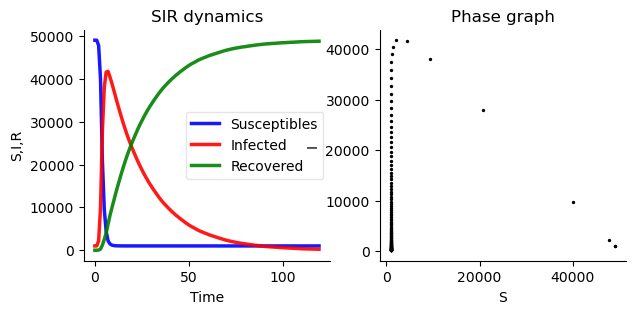

In [ ]:
# fig, axs = plt.subplots(nrows=1, ncols=2, facecolor='w', figsize=(7,3))

# ax = axs[0]
# ax.set_title('SIR dynamics')
# ax.plot(RES.index, RES.Susceptibles, 'b', alpha=0.9, lw=2.5, label= 'Susceptibles')
# ax.plot(RES.index, RES.Infected, 'r', alpha=0.9, lw=2.5, label= 'Infected')
# ax.plot(RES.index, RES.Recovered, 'g', alpha=0.9, lw=2.5, label= 'Recovered')
# ax.set_xlabel('Time')
# ax.set_ylabel('S,I,R')
# legend = ax.legend()
# legend.get_frame().set_alpha(0.5)

# for spine in ('top', 'right'): 
#     ax.spines[spine].set_visible(False)

# ax = axs[1]
# ax.set_title('Phase graph')
# ax.scatter(RES.Susceptibles, RES.Infected ,s=2, facecolor='k')

# ax.set_xlabel('S')
# ax.set_ylabel('I')


# for spine in ('top', 'right'): 
#     ax.spines[spine].set_visible(False)

A function was then defined to collect the data from the datacollector in a more ordinate way so that the plotting could be facilitated. In particular, the values, over time, of all the compartments S, I, and R are saved in a list associated to the respective compartment in the respectove airport. 

In [26]:
def find_development(df):
    development=defaultdict(list)
    airport_tags=list(airports["iata"])
    for j in range(len(df)):
        for i in airport_tags:
            development[f"I_{i}"].append(df.loc[j, "Infected"][i])
            development[f"S_{i}"].append(df.loc[j, "Susceptibles"][i])
            development[f"R_{i}"].append(df.loc[j, "Recovered"][i])
    return development


The above defined function was then called and keys were sorted for facility of plotting:

In [27]:
for_plot=find_development(RES)
sorted_keys = sorted(for_plot.keys())

And the plots were obtained:

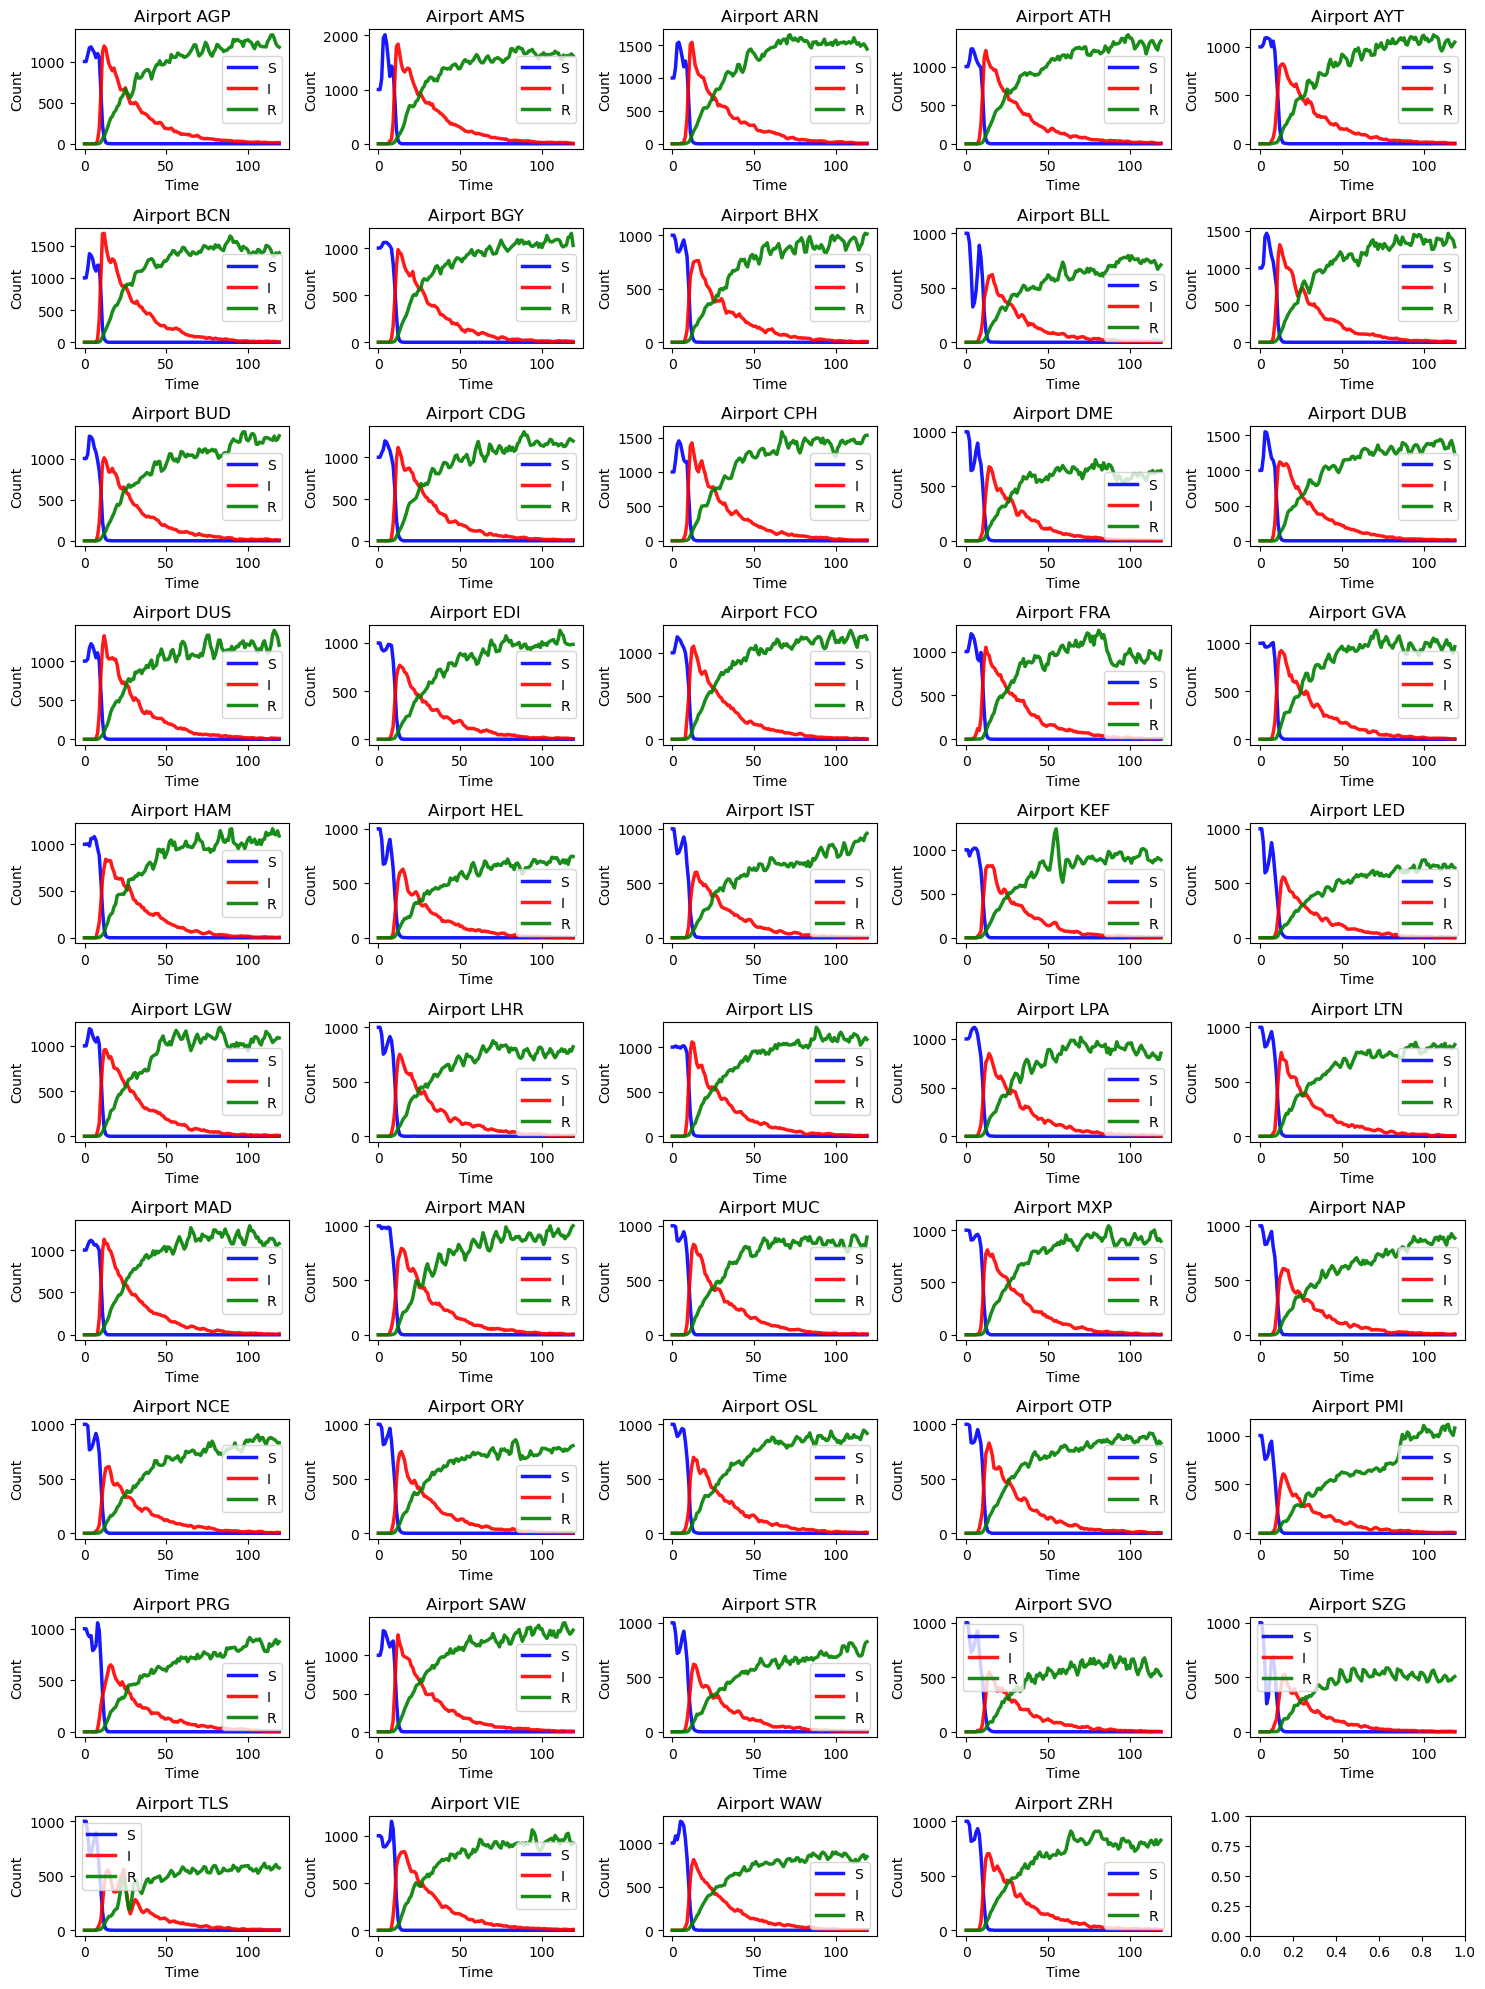

In [28]:
fig, axs = plt.subplots(10, 5, figsize=(15, 20))
axs = axs.flatten()
for i in range(49):
    ax = axs[i]
    ax.plot(for_plot[sorted_keys[i + (2 * 49)]], 'b', alpha=0.9, lw=2.5, label='S')
    ax.plot(for_plot[sorted_keys[i]], 'r', alpha=0.9, lw=2.5, label='I')
    ax.plot(for_plot[sorted_keys[i + 49]], 'g', alpha=0.9, lw=2.5, label='R')
    ax.set_title(f"Airport {sorted_keys[i].split('_')[1]}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Count")
    ax.legend()

plt.tight_layout()
plt.show()

In [134]:
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.modules import NetworkModule, ChartModule, TextElement

def agent_portrayal(agent):
    if agent is None:
        return
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "Color": "grey",
                 "Layer": 0,
                 "r": 0.7}
    
    if agent.health == 'Infected':
        portrayal["Color"] = "red"
        portrayal["Layer"] = 1
        portrayal["r"] = 0.4
    elif agent.health == 'Susceptible':
        portrayal["Color"] = "blue"
    elif agent.health == 'Recovered':
        portrayal["Color"] = "green"
        portrayal["Layer"] = 2
        portrayal["r"] = 0.15
    return portrayal

network = NetworkModule(agent_portrayal, 500, 500)
chart1 = ChartModule([{"Label": "Infected", "Color": "red"},
                      {"Label": "Susceptibles", "Color": "blue"},
                      {"Label": "Recovered", "Color": "green"}])

server = ModularServer(SIR_Model,
                       [network, chart1],
                       "SIR Model",
                       {'air_cap':air_cap , 'beta': 2.6, 'gamma': 6.6, 'beg_day': '2023-01-01', "beg_airports":start_airports, "airports":airports, "flights":fj, "dest":flight_dict, "prob":prob})
server.port = 8888
server.launch()

Interface starting at http://127.0.0.1:8888


RuntimeError: This event loop is already running

Socket opened!
{"type":"reset"}


ERROR:tornado.application:Uncaught exception GET /ws (127.0.0.1)
HTTPServerRequest(protocol='http', host='127.0.0.1:8888', method='GET', uri='/ws', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/tornado/websocket.py", line 635, in _run_callback
    result = callback(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/mesa/visualization/ModularVisualization.py", line 236, in on_message
    self.write_message(self.viz_state_message)
  File "/opt/anaconda3/lib/python3.8/site-packages/mesa/visualization/ModularVisualization.py", line 219, in viz_state_message
    return {"type": "viz_state", "data": self.application.render_model()}
  File "/opt/anaconda3/lib/python3.8/site-packages/mesa/visualization/ModularVisualization.py", line 393, in render_model
    element_state = element.render(self.model)
  File "/opt/anaconda3/lib/python3.8/site-packages/mesa/visualization/modules/NetworkVisualizatio